In [343]:
from fastai.vision.all import *
from fastai.vision import *
from fastai.metrics import accuracy
#from fastai.basic_data import *
#from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import cv2
from skimage.util import montage
from matplotlib.image import BboxImage
import numpy as np

In [344]:
path = "Test_images/"

In [345]:
def gridBbox(bbox, imgRes, imgOri, grids, nRows, nCols):
    # Param:
    #   bbox: minx miny maxX maxY
    #   grids: numpy array that stores each generated grid from bbox  
    #   TODO: params nRows & nCols must be removed after optimizing the code 

    # NOTE: Example of bbox: [[array([ 87.5,  70. , 240.5, 458. ])], ['0']]
    # NOTE: Coordinates have decimals, they must be truncated 
    # NOTE: For the moment, make all grids the same size 
    # NOTE: Don't take into account nGrids to be a prime number 
    # NOTE: Number of grids must be greater than one 

    # Paint vertical lines of bboxLeft 
    #image_res[:, int(bboxLeft[0])] = (255, 0, 0) 
    #image_res[:, int(bboxLeft[2])] = (255, 0, 0) 

    # Paint vertical lines of bboxRight 
    #image_res[:, int(bboxRight[0])] = (255, 0, 0)  
    #image_res[:, int(bboxRight[2])] = (255, 0, 0) 

    # Paint horizontal lines
    # NOTE: For the moment, just use bboxLeft. In the future, should use both bbox
    # and check which has the horizontal line more up/down
    #image_res[int(bboxRight[1]), int(bboxLeft[0]): int(bboxRight[2])] = (255, 0, 0) 
    #image_res[int(bboxRight[3]), int(bboxLeft[0]): int(bboxRight[2])] = (255, 0, 0) 

    # Paint borders of the bbox 
    # x axis of imgRes (openCV format) refers to the columns
    # y axis refers to the rows 
    # to access a pixel of imgRes we should do imgRes[y,x] as we would access a value of a matrix
    # Do the same when accessing a pixel of imgOri
    # More info at: https://pyimagesearch.com/2021/01/20/opencv-getting-and-setting-pixels/

    # Vertical borders 
    imgRes[int(bbox[1]): int(bbox[3]), int(bbox[0])] = (255, 0, 0) # (R,G,B)
    imgRes[int(bbox[1]): int(bbox[3]), int(bbox[2])] = (255, 0, 0) 
    # Horizontal borders 
    imgRes[int(bbox[1]), int(bbox[0]) : int(bbox[2])] = (255, 0, 0) 
    imgRes[int(bbox[3]), int(bbox[0]) : int(bbox[2])] = (255, 0, 0) 

    # TODO: param grids length should be nGrids, not the nRows * nCols 
    # Get the number of grids for the bbox
    # nGrids = len(grids)  
    
    # TODO: Get the number of rows and columns 
    # nRows * nCols = nGrids
    # nRows has to be greater or equal than nCols because 
    # the bboxes are taller than wide 
    # NOTE: For the moment, nRows & nCols are given as params 
    #nRows = 0
    #nCols = 0
    
    # Get the size of each grid 
    gridHeight = (bbox[3] - bbox[1]) / nRows # (maxY - minY) / nRows
    gridWidth = (bbox[2] - bbox[0]) / nCols # (maxX - minX) / nCols
    
    # Obtain the grids and paint their borders in red 
    x = bbox[0] # minx
    y = bbox[1] # miny
    for nGrids in range(nRows*nCols): # nIterations = number of grids
        grids[nGrids] = imgOri[int(y): int(y + gridHeight), int(x): int(x + gridWidth)]        
        x = x + gridWidth
        # check if x (column index) has reached the right border of the bbox        
        if (x < bbox[2]): # check if x < maxX
            # paint vertical line of the added grid 
            imgRes[int(bbox[1]):int(bbox[3]), int(x)] = (255, 0, 0) 
        # right border reached 
        else: 
            x = bbox[0] # set x to minX 
            # paint horizontal line 
            y = y + gridHeight
            imgRes[int(y), int(bbox[0]): int(bbox[2])] = (255, 0, 0) 
    

In [346]:
# Get the annotations associated to an image 

def img2txt_name(f):
    f = os.path.basename(f)
    return path + f'{str(f)[:-4]}.txt'

In [347]:
# Generate the bounding boxes of an image with Path "f"
#   "f" is a Path and not a filename because the DataBlock object used next gets the paths 
#   of all the images of the dataset & stores them in a list named "get_image_files"
#   For each image of the dataset, it's path is passed as parameter in get_bboxes to generate the target bounding boxes 
def get_bboxes(f):
    
    img = PILImage.create(path+f.name)

    # Get the annotations of the bounding boxes of the lungs of the rx image with Path "f"
    fullAnnot = np.genfromtxt(img2txt_name(f))

    bboxes = np.zeros((2,4))

    for i in range(len(fullAnnot)):
        cx = int(fullAnnot[i][1]*img.size[0]) 
        cy = int(fullAnnot[i][2]*img.size[1])
        
        w = int(fullAnnot[i][3]*img.size[0])
        h = int(fullAnnot[i][4]*img.size[1])
        
        bbox = np.zeros(4)
        bbox[0] = float(cx-w/2.0) # minx 
        bbox[1] = float(cy-h/2.0) # miny
        bbox[2] = float(cx+w/2.0) # maxX
        bbox[3] = float(cy+h/2.0) # maxY

        bboxes[i] = bbox

    return bboxes

def get_labels(f):
    fullAnnot = np.genfromtxt(img2txt_name(Path(f)))
    labels = fullAnnot[:,0]
    return labels

In [348]:
imageName = input("Enter the name of the image: ")
imagePath = path + imageName + ".png"
bboxes = get_bboxes(Path(imagePath)) # bboxes is a 2x4 numpy array 

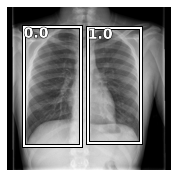

In [349]:
# Show the bounding boxes

def get_LabeledBBoxes (bboxes): return LabeledBBox(TensorBBox(bboxes[0]),bboxes[1]) 

labeledBboxes = [bboxes, get_labels(Path(imagePath))]
tbboxes = get_LabeledBBoxes(labeledBboxes)

img = PILImage.create(imagePath)
ctx = img.show(figsize=(3,3), cmap='Greys')
tbboxes.show(ctx=ctx);

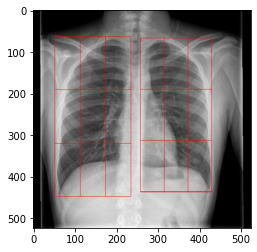

<Figure size 432x288 with 0 Axes>

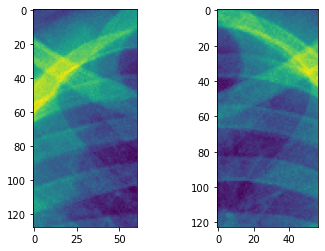

In [350]:

# ---------------------------------------

# ALTERNATIVE IMPLEMENTATION: 

# 1. Enter the number of grids of the 2 lungs combined
#nGrids = int(input("Entra el nombre de quadricules que vols generar: "))
#grids = np.zeros(nGrids, object)

# 2. Enter the number of grids for each lung
# Instead of creating just one grids list, I could create two lists (gridsLeftLung, gridsRightLung) to 
# make more clear which grids belong to the left lung and which ones to the right lung
#nGrids = int(input("Enter the number of grids for each lung: "))
#gridsLungLeft = np.zeros(nGrids, object) 
#gridsLungRight = np.zeros(nGrids, object) 

# ---------------------------------------

# CURENT IMPLEMENTATION 

# To avoid obtaining nRows & nCols from nGrids pass them as input 
nRows = int(input("Enter the number of rows to grid each lung: "))
nCols = int(input("Enter the number of columns to grid each lung: "))

gridsLungLeft = np.zeros(nRows * nCols, object) 
gridsLungRight = np.zeros(nRows * nCols, object) 

imgRes = cv2.imread(imagePath)

# NOTE: I read again the BW image that was previously readen because 
# I need it as an array, not as a PILImage type to be able to access the pixels values 
imgOri = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE) 

#grid(bboxLeft[0][0], bboxRight[0][0], imgColor, imgOri, grids)
# NOTE: Instead of calling just one time grid(), we could make two calls 
# for the first one pass the bbox of the left lung and for the second one pass the bbox of the right lung 

# It's better to call grid() for each bbox because they can have different size 
# gridsLungLeft & gridsLungRight can be merged later if necessary 
gridBbox(bboxes[0], imgRes, imgOri, gridsLungLeft, nRows, nCols) # grid bbox left
gridBbox(bboxes[1], imgRes, imgOri, gridsLungRight, nRows, nCols) # grid bbox right

# TODO: Take out the axis values of the image
plt.imshow(imgRes)

plt.figure()

f, axarr = plt.subplots(1,2) 

gridSelected = int(input("Enter the grid number of the left lung you want to see: "))
axarr[0].imshow(gridsLungLeft[gridSelected])

gridSelected = int(input("Enter the grid number of the right lung you want to see: "))
axarr[1].imshow(gridsLungRight[gridSelected])